In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from model import Encoder, Decoder, VQEmbedding, VAE
from utils import AnimeImageDataset,\
      train_test_split, train, load_checkpoint
from eval import draw_sample_image, plot_train_loss,\
      generate_images, inception_score

## Hyperparameters

In [ ]:
img_size = (256, 256)

input_dim = 3
hidden_dim = 512
latent_dim = 22
n_embeddings= 512
output_dim = 3
commitment_beta = 0.25

lr = 0.00005

In [ ]:
transform = transforms.Compose([
    transforms.Resize(img_size),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [ ]:
root_dir = '/content/drive/MyDrive/Cogs 185 Final Project/Anime_Dataset/Anime_Dataset'
dataset = AnimeImageDataset(root_dir=root_dir, transform=transform)

# Train-test split
train_dataset, test_dataset = train_test_split(dataset, test_ratio=0.2)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim).to(device)
codebook = VQEmbedding(n_embeddings=n_embeddings, embedding_dim=latent_dim).to(device)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
model = VAE(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)

In [ ]:
model

VAE(
  (encoder): Encoder(
    (strided_conv_1): Conv2d(3, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (strided_conv_2): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (residual_conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual_conv_2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (proj): Conv2d(512, 22, kernel_size=(1, 1), stride=(1, 1))
  )
  (codebook): VQEmbeddingEMA()
  (decoder): Decoder(
    (in_proj): Conv2d(22, 512, kernel_size=(1, 1), stride=(1, 1))
    (residual_conv_1): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (residual_conv_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (strided_t_conv_1): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (strided_t_conv_2): ConvTranspose2d(512, 3, kernel_size=(2, 2), stride=(2, 2))
  )
)

In [ ]:
# Load checkpoint if we have
load_checkpoint(model, 'vae_anime.pt')

In [ ]:
total_loss, rec_loss, cb_loss = train(model, train_dataloader, 
                                      latent_dim=latent_dim, epochs=50, 
                                      device=device, lr=lr, 
                                      commitment_beta=commitment_beta)

Epoch 1, Rec Loss: 0.0309, Codebook Loss: 0.1795, Total Loss: 0.2217
Epoch 2, Rec Loss: 0.0209, Codebook Loss: 0.2157, Total Loss: 0.2500
Epoch 3, Rec Loss: 0.0186, Codebook Loss: 0.2249, Total Loss: 0.2575
Epoch 4, Rec Loss: 0.0213, Codebook Loss: 0.2770, Total Loss: 0.3156
Epoch 5, Rec Loss: 0.0108, Codebook Loss: 0.1457, Total Loss: 0.1656
Epoch 6, Rec Loss: 0.0127, Codebook Loss: 0.1712, Total Loss: 0.1946
Epoch 7, Rec Loss: 0.0084, Codebook Loss: 0.1587, Total Loss: 0.1771
Epoch 8, Rec Loss: 0.0123, Codebook Loss: 0.2226, Total Loss: 0.2488
Epoch 9, Rec Loss: 0.0130, Codebook Loss: 0.2099, Total Loss: 0.2360
Epoch 10, Rec Loss: 0.0094, Codebook Loss: 0.1639, Total Loss: 0.1835
Epoch 11, Rec Loss: 0.0114, Codebook Loss: 0.1995, Total Loss: 0.2233
Epoch 12, Rec Loss: 0.0064, Codebook Loss: 0.1095, Total Loss: 0.1227
Epoch 13, Rec Loss: 0.0086, Codebook Loss: 0.1488, Total Loss: 0.1666
Epoch 14, Rec Loss: 0.0075, Codebook Loss: 0.1453, Total Loss: 0.1618
Epoch 15, Rec Loss: 0.0068, C

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, x in enumerate(tqdm(test_dataloader)):
        x = x.to(device)
        x_hat, commitment_loss, codebook_loss = model(x)
        break

  0%|          | 0/32 [00:02<?, ?it/s]


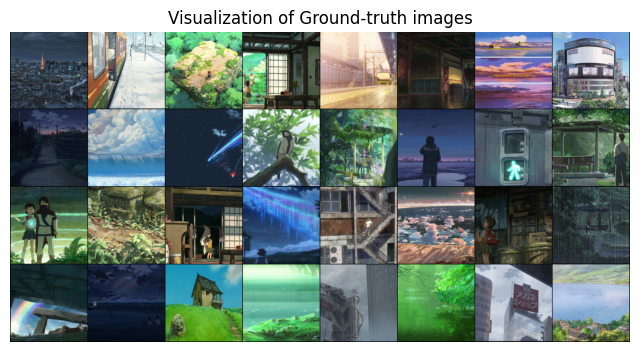

In [ ]:
draw_sample_image(x, "Ground-truth images")

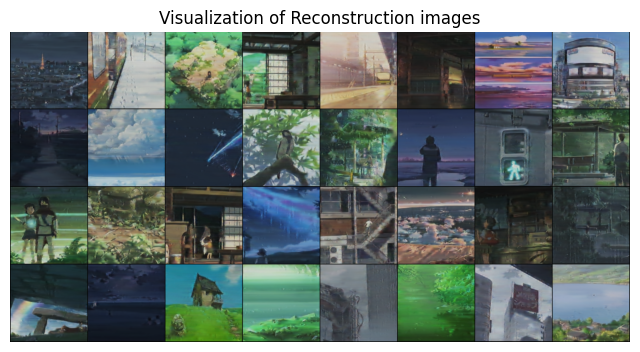

In [ ]:
draw_sample_image(x_hat, "Reconstruction images")

## Loss Visualization

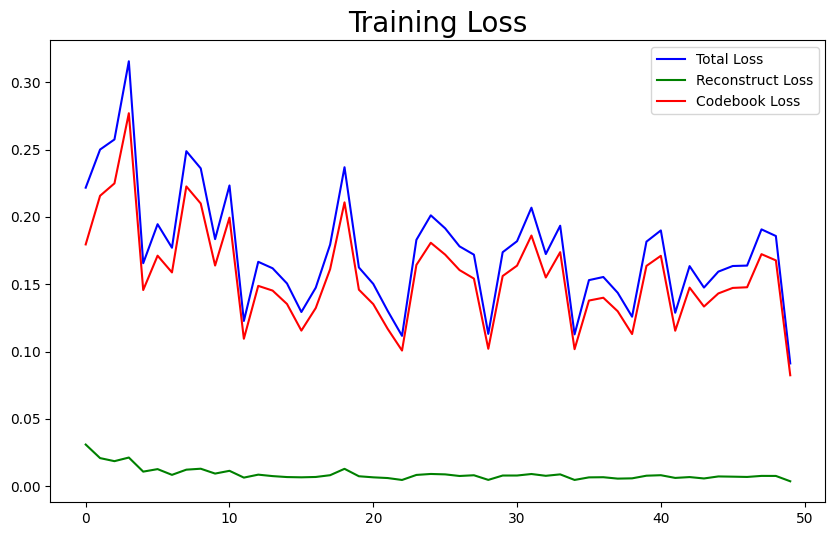

In [ ]:
plot_train_loss(total_loss, rec_loss, cb_loss)

## Inception Score

In [ ]:
gen_path='./reconstruct/'
test_path='./original'
generate_images(model, test_dataloader, device=device, 
                gen_path=gen_path, test_path=test_path)

100%|██████████| 32/32 [01:12<00:00,  2.25s/it]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299), interpolation=Image.LANCZOS),  # upsample to 299x299
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

gen_set = AnimeImageDataset(image_folder=gen_path, transform=transform)
gen_loader = DataLoader(gen_set, batch_size=32, shuffle=False, num_workers=32)
test_set = AnimeImageDataset(image_folder=test_path, transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=32)

In [ ]:
mean, std = inception_score(test_loader, cuda=True, batch_size=32, splits=10)
print(f"Original Image Inception Score: {mean} ± {std}")
mean, std = inception_score(gen_loader, cuda=True, batch_size=32, splits=10)
print(f"Reconstructed Image Inception Score: {mean} ± {std}")

Original Image Inception Score: 2.192984247188833 ± 0.2148887187699547
Reconstructed Image Inception Score: 1.9646838225051024 ± 0.22497996406248974


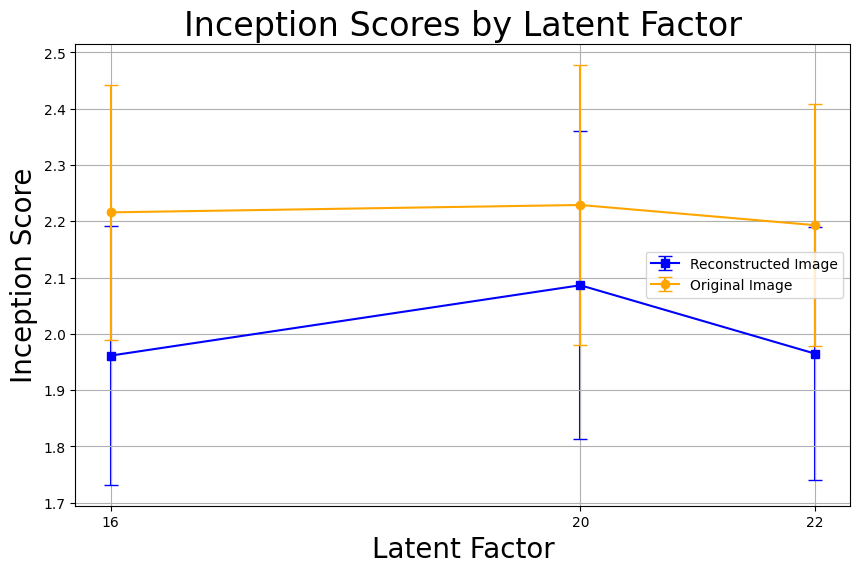

In [ ]:
import matplotlib.pyplot as plt

# Data by previous observed
latent_factors = [16, 20, 22]
original_means = [2.2158, 2.2289, 2.1930]
original_stds = [0.2262, 0.2492, 0.2149]
reconstructed_means = [1.9613, 2.0863, 1.9647]
reconstructed_stds = [0.2294, 0.2735, 0.2250]

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(latent_factors, reconstructed_means, yerr=reconstructed_stds, fmt='s-', capsize=5, label='Reconstructed Image', color='blue')
plt.errorbar(latent_factors, original_means, yerr=original_stds, fmt='o-', capsize=5, label='Original Image', color='orange')

plt.title('Inception Scores by Latent Factor', fontsize=24)
plt.xlabel('Latent Factor', fontsize=20)
plt.ylabel('Inception Score', fontsize=20)
plt.xticks(latent_factors)
plt.gca().collections[-2].set_zorder(1)
plt.gca().lines[-2].set_zorder(2)
plt.legend()
plt.grid(True)
plt.show()
